In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
import math
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import *
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
from google.colab import files
uploaded = files.upload()
import io
# df2 = pd.read_csv(io.BytesIO(uploaded['ACN.csv'])) 
# df2 = pd.read_csv(io.BytesIO(uploaded['AMZN.csv'])) 
# df2 = pd.read_csv(io.BytesIO(uploaded['AAPL.csv'])) 
# df2 = pd.read_csv(io.BytesIO(uploaded['DELL.csv']))  
# df2 = pd.read_csv(io.BytesIO(uploaded['UBER.csv'])) 
# df2 = pd.read_csv(io.BytesIO(uploaded['VZ.csv'])) 
# df2 = pd.read_csv(io.BytesIO(uploaded['FB.csv'])) 

df2 = pd.read_excel(io.BytesIO(uploaded['amzn.xlsx'])) 



In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date',inplace=True)


In [ ]:
df2.tail()

In [ ]:
#plotting the data
plt.figure(figsize=(20,10))
plt.title('Close Price History',fontsize = 50)
plt.plot(df2['Close'], color='red')
plt.xlabel('Date', fontsize=30)
plt.ylabel('Close Price USD', fontsize = 30)
plt.xticks(fontsize = 20)    
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
# create a new data frame with only 'Close column'
data = df2.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)  # number of rows to train the model on
# print(training_data_len)
# data.tail()

In [ ]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# scaled_data

In [ ]:
result = []
sequence_length = 6
for index in range(len(scaled_data) - sequence_length):
    result.append(scaled_data[index: index + sequence_length])
    
result = np.array(result)
row = round(0.8 * result.shape[0])
training_data_len = int(row)
#creating training data
train = result[:int(row), :]

x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

amount_of_features = 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features)) 

print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (4634, 5, 1)
y_train (4634,)
X_test (1158, 5, 1)
y_test (1158,)


In [ ]:
model = Sequential()
# input = [1,14,1]
# model.add(Dense(128,input_shape=(x_train.shape[1],1)))
model.add(Conv1D(filters = 128, kernel_size= 1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
# model.add(Dropout(0.2))
model.add(Conv1D(filters = 64,kernel_size = 1,padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
# model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(16,return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
# model.compile(loss='mse',optimizer='adam',metrics=['mse'])
model.compile(optimizer=adam, loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 5, 128)            256       
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 2, 64)             8256      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 1, 32)             12416     
_________________________________________________________________
lstm_66 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_72 (Dense)             (None, 32)              

In [ ]:
# model =Sequential()
# model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences= False))
# model.add(Dropout(0.2))
# model.add(Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same'))
# model.add(BatchNormalization())
# model.add(Dense(32))
# model.add(Dense(1))


#Complie the model
adam = Adam(lr=0.003)
# model.compile(optimizer=adam, loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
callbacks = [early_stopping, reduce_lr]
# callbacks = [reduce_lr]


In [ ]:
model.fit(x_train,y_train, validation_data=(x_test, y_test), callbacks=callbacks,batch_size=100, epochs=100)
# model.fit(x_train,y_train, callbacks=callbacks,batch_size=100, epochs=100)

Train on 4634 samples, validate on 1158 samples
Epoch 1/100
4634/4634 [==============================] - 1s 283us/step - loss: 0.0025 - root_mean_squared_error: 0.0531 - val_loss: 0.2727 - val_root_mean_squared_error: 0.1381
Epoch 2/100
4634/4634 [==============================] - 0s 66us/step - loss: 0.0010 - root_mean_squared_error: 0.2031 - val_loss: 0.1296 - val_root_mean_squared_error: 0.1847
Epoch 3/100
4634/4634 [==============================] - 0s 66us/step - loss: 3.7854e-05 - root_mean_squared_error: 0.1864 - val_loss: 0.0859 - val_root_mean_squared_error: 0.1742
Epoch 4/100
4634/4634 [==============================] - 0s 61us/step - loss: 1.0838e-05 - root_mean_squared_error: 0.1718 - val_loss: 0.0664 - val_root_mean_squared_error: 0.1633
Epoch 5/100
4634/4634 [==============================] - 0s 62us/step - loss: 8.3211e-06 - root_mean_squared_error: 0.1607 - val_loss: 0.0598 - val_root_mean_squared_error: 0.1544
Epoch 6/100
4634/4634 [==============================] - 0s

In [ ]:
#predicting the data
predictions = model.predict(x_test)
# print(y_test)
y_act = scaler.inverse_transform(y_test.reshape(y_test.shape[0], 1))
# print(y_act)
predictions = scaler.inverse_transform(predictions)
# print(predictions)

In [ ]:
#get the root mean square error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_act)**2)
rmse

446.40010215247025

(1158, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Unrecognized location 'upper_center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  del sys.path[0]


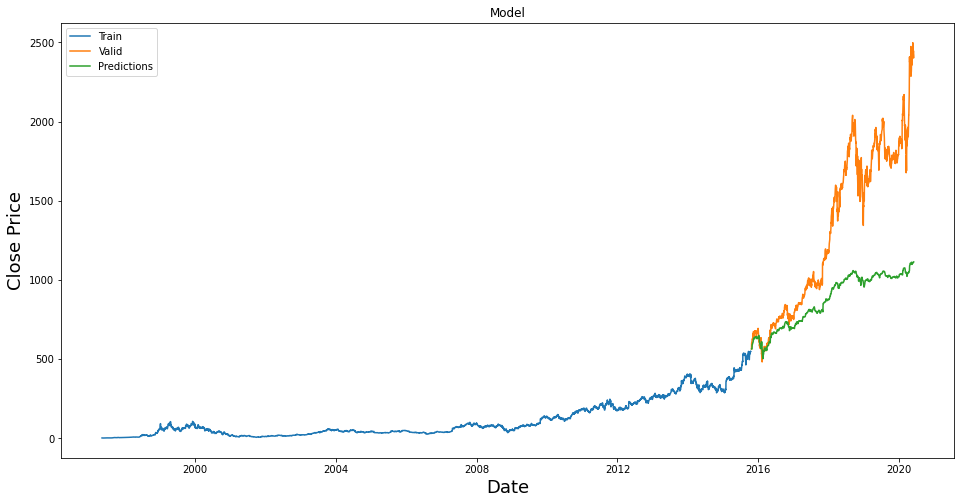

In [ ]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len+6:]
print(valid.shape)
valid['Predictions'] = predictions
#Visialization the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(train['Close'],linewidth=1.5)
plt.plot(valid[['Close','Predictions']],linewidth=1.5)
plt.legend(['Train','Valid','Predictions'], loc='upper_center')

In [ ]:
valid['difference'] = valid['Close'] - valid['Predictions']
valid.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Close,Predictions,difference
Date,,,
2020-05-22,2436.879883,1108.566406,1328.313477
2020-05-26,2421.860107,1113.667969,1308.192138
2020-05-27,2410.389893,1113.667969,1296.721924
2020-05-28,2401.100098,1113.667969,1287.432129
2020-05-29,2442.370117,1113.667969,1328.702148
